In [72]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
# hv.extension('matplotlib')
import panel as pn
from holoviews import opts
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import glob
import os
import pytz
from timezonefinder import TimezoneFinder

In [2]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

### Functions

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [4]:
tf = TimezoneFinder() 

# Function to convert local standard time (no DLS) time to UTC
def local_std_to_utc_std(df,col,lat,lon):
    def convert_row(row):
        # Find the timezone for the given lat/lon
        timezone_str = tf.timezone_at(lat=lat, lng=lon)
        if timezone_str is not None:
            timezone = pytz.timezone(timezone_str)
            # Localize datetime without DST
            standard_time = timezone.normalize(timezone.localize(row[col], is_dst=False))
            # Convert to UTC
            return standard_time.astimezone(pytz.utc)
        else:
            raise ValueError('Cannot determine site time zone')
            
    df['utc_time'] = df.apply(convert_row,axis=1)
    return df

In [5]:
# Function to obtain location data
def get_loc_data(site_ID):
    
    ## Fluxnet Data 
    # Import selected site half-hourly data (HH) Subset data
    timedelta = 'HH'
    
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    filepath = 'ameriflux-data/'
    sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects
    fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
    fluxnet_sel_simple['TIMESTAMP_START'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
    fluxnet_sel_simple['TIMESTAMP_END'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_END'],format='%Y%m%d%H%M')

    # Convert time zone (Fluxnet reported in local standard time)
    fluxnet_sel_simple = local_std_to_utc_std(fluxnet_sel_simple,'TIMESTAMP_START',site_lat, site_lon)
    fluxnet_sel_simple = fluxnet_sel_simple.set_index('utc_time')

    # Convert units
    # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
    fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'

    # resample to 3-hourly per MiCASA
    # Maybe don't resample so that I can carry the QC values?
    # fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean()
    
    # Import MiCASA from data-extract.py
    dir = 'output'
    timedelta = 'HH'
    filename = f'{site_ID}_micasa_{timedelta}.csv'
    path = os.path.join(dir, filename)
    micasa_ds = pd.read_csv(path,index_col=0)

    # Create datetime index and specify UTC
    micasa_ds.index = pd.to_datetime(micasa_ds.index)
    micasa_ds.index = micasa_ds.index.tz_localize('UTC')
    micasa_ds.index.name = 'utc_time'

    # Append together
    # Can't append together if I don't resample
    # plot_ds = micasa_ds.merge(fluxnet_sel_final,left_index=True, right_index=True)
    return plot_ds

In [6]:
# Function to plot data
def hv_plot_data(dataset):
    # Define misc plotting variables
    datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
    
    # tick_locations = pd.date_range(dataset.index.min(), dataset.index.max(), freq='12h').values
    # tick_locations_ms = tick_locations.astype(int) //10**6 # Convert to milliseconds so bokeh can interpret
    plot = dataset.hvplot(
        kind='line',
        width=1300, height=500,
        # groupby=['utc_time.year'],
        groupby=['utc_time.year', 'utc_time.month'],
        widget_location='bottom',
        xformatter= datetimeformatter,
        # xticks = tick_locations_ms,        
        yformatter='%.1e',
        ylabel = 'NEE (kg C m-2 s-1)',
        title = f'{site_ID} (3-Hour Averages)',
        legend='bottom',
        grid=True,
    )    
    return plot

### Import data

In [7]:
# Import site metadata csv
filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
# fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

In [8]:
# Example sites of varying geography/climates
site_list = ['US-A32', 'US-Bar', 'US-RGB', 'US-xJE', 'US-SRC']
sites_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'].isin(site_list)]
sites_meta

,Site ID,Name,Principal Investigator,Data Use Policy,AmeriFlux BASE Data,AmeriFlux FLUXNET Data,Vegetation Abbreviation (IGBP),Vegetation Description (IGBP),Climate Class Abbreviation (Koeppen),Climate Class Description (Koeppen),...,Longitude (degrees),Elevation (m),Years of AmeriFlux BASE Data,AmeriFlux BASE DOI,Years of AmeriFlux FLUXNET Data,AmeriFlux FLUXNET DOI,Site Start,Site End,BASE variables available,FLUXNET variables available
133,US-A32,ARM-SGP Medford hay pasture,Sebastien Biraud (scbiraud@lbl.gov),CC-BY-4.0,Yes,Yes,GRA,Grasslands: Lands with herbaceous types of cov...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-97.8198,335.0,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1436327,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1881568,2015.0,2017.0,"ALB, CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, ND...",NaN
157,US-Bar,Bartlett Experimental Forest,Andrew Richardson (Andrew.Richardson@nau.edu),CC-BY-4.0,Yes,Yes,DBF,Deciduous Broadleaf Forests: Lands dominated b...,Dfb,Warm Summer Continental: significant precipita...,...,-71.2881,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/1246030,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/2006969,2004.0,NaN,"CO2, FC, H, LE, NETRAD, P, PA, PPFD_BC_IN, PPF...",NaN
477,US-RGB,Butte County Rice Farm,Sebastien C. Biraud (SCBiraud@lbl.gov),CC-BY-4.0,Yes,Yes,CRO,Croplands: Lands covered with temporary crops ...,Csa,"Mediterranean: mild with dry, hot summer",...,-121.8579,33.0,"2021, 2022, 2023",https://doi.org/10.17190/AMF/1870591,2021,https://doi.org/10.17190/AMF/2204874,2021.0,NaN,"CO2, FC, FC_SSITC_TEST, FETCH_70, FETCH_80, FE...",NaN
530,US-SRC,Santa Rita Creosote,Shirley (Kurc) Papuga (shirley.papuga@gmail.com),CC-BY-4.0,Yes,Yes,OSH,Open Shrublands: Lands with woody vegetation l...,Bwh,Desert: warm winter,...,-110.8395,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1246127,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1871145,2008.0,2018.0,"CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, NETRAD,...",NaN
640,US-xJE,NEON Jones Ecological Research Center (JERC),National Ecological Observatory Network (neon-...,CC-BY-4.0,Yes,Yes,ENF,Evergreen Needleleaf Forests: Lands dominated ...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-84.4686,44.0,"2017, 2018, 2019, 2020, 2021, 2022, 2023",https://doi.org/10.17190/AMF/1617730,"2017, 2018, 2019, 2020, 2021",https://doi.org/10.17190/AMF/1985443,2017.0,NaN,"CH4, CH4_MIXING_RATIO, CO2, CO2C13, CO2_MIXING...",NaN


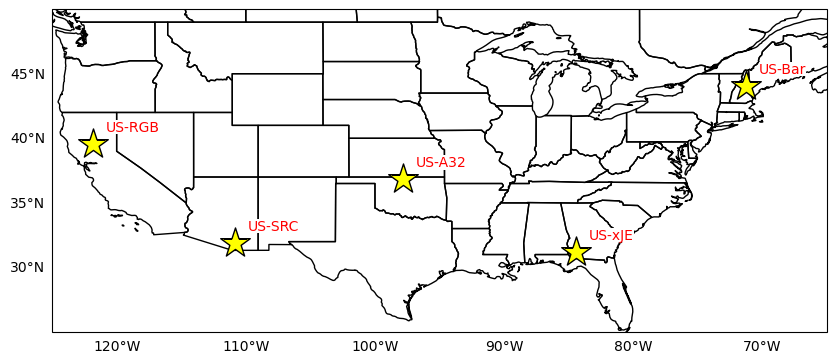

In [9]:
# Plot sites
proj=ccrs.PlateCarree()

# Subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(10,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)

for site_ID in site_list:
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3)
    
    ax.annotate(site_ID, (site_lon + 1,site_lat+1),
                color='red',
                bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                         )
                         
               )

gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [10]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

# Testing

In [11]:
timedelta = 'HH'
site_ID =  'US-A32'

In [58]:
# Import micasa
dir = 'output'
filename = f'{site_ID}_micasa_{timedelta}.csv'
path = os.path.join(dir, filename)
micasa_ds = pd.read_csv(path,index_col=0)

# Create datetime index and specify UTC
micasa_ds.index = pd.to_datetime(micasa_ds.index)
micasa_ds.index = micasa_ds.index.tz_localize('UTC')
micasa_ds.index.name = 'utc_time'
micasa_ds.head()

,MiCASA NEE (kgC m-2 s-1)
utc_time,
2015-01-01 00:00:00+00:00,4.376675e-09
2015-01-01 03:00:00+00:00,4.236837e-09
2015-01-01 06:00:00+00:00,4.143609e-09
2015-01-01 09:00:00+00:00,4.105323e-09
2015-01-01 12:00:00+00:00,3.566877e-09


In [13]:
# Test of QC
site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')

fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + convert to datetime objects
fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
fluxnet_sel_simple['TIMESTAMP_START'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
fluxnet_sel_simple['TIMESTAMP_END'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_END'],format='%Y%m%d%H%M')

# Convert time zone (Fluxnet reported in local standard time)
fluxnet_sel_simple = local_std_to_utc_std(fluxnet_sel_simple,'TIMESTAMP_START',site_lat, site_lon)
fluxnet_sel_simple = fluxnet_sel_simple.set_index('utc_time')

# Convert units
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_simple = fluxnet_sel_simple.copy()
fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
fluxnet_sel_simple

,TIMESTAMP_START,TIMESTAMP_END,NEE_VUT_REF,NEE_VUT_REF_QC,FluxNET NEE (kgC m-2 s-1)
utc_time,,,,,
2015-01-01 06:00:00+00:00,2015-01-01 00:00:00,2015-01-01 00:30:00,7.92735,3,9.520747e-08
2015-01-01 06:30:00+00:00,2015-01-01 00:30:00,2015-01-01 01:00:00,7.71382,3,9.264298e-08
2015-01-01 07:00:00+00:00,2015-01-01 01:00:00,2015-01-01 01:30:00,7.47549,3,8.978063e-08
2015-01-01 07:30:00+00:00,2015-01-01 01:30:00,2015-01-01 02:00:00,7.42830,3,8.921388e-08
2015-01-01 08:00:00+00:00,2015-01-01 02:00:00,2015-01-01 02:30:00,7.75467,3,9.313359e-08
...,...,...,...,...,...
2018-01-01 03:30:00+00:00,2017-12-31 21:30:00,2017-12-31 22:00:00,8.47052,3,1.017309e-07
2018-01-01 04:00:00+00:00,2017-12-31 22:00:00,2017-12-31 22:30:00,8.29279,3,9.959641e-08
2018-01-01 04:30:00+00:00,2017-12-31 22:30:00,2017-12-31 23:00:00,8.12681,3,9.760299e-08


In [14]:
# Quality flag for NEE_VUT_REF: 0 = measured; 1 = good quality gapfill; 2 = medium; 3 = poor
fluxnet_sel_simple.hvplot(
    kind='scatter',
    x='utc_time',
    y='FluxNET NEE (kgC m-2 s-1)',
    by='NEE_VUT_REF_QC',
    width=1200, height=500,
    # groupby=['utc_time.year'],
    # widget_location='bottom',
    title='Raw FluxNet Half-Hourly',
    ylabel = 'NEE (kg C m-2 s-1)',
    
)

:NdOverlay   [NEE_VUT_REF_QC]
   :Scatter   [utc_time]   (FluxNET NEE (kgC m-2 s-1))

In [15]:
# Mask bad QC values
fluxnet_sel_QC0 = fluxnet_sel_simple['FluxNET NEE (kgC m-2 s-1)'].mask(fluxnet_sel_simple['NEE_VUT_REF_QC'] == 3, np.nan).mask(fluxnet_sel_simple['NEE_VUT_REF_QC'] == 2, np.nan)
fluxnet_sel_QC0

utc_time
2015-01-01 06:00:00+00:00   NaN
2015-01-01 06:30:00+00:00   NaN
2015-01-01 07:00:00+00:00   NaN
2015-01-01 07:30:00+00:00   NaN
2015-01-01 08:00:00+00:00   NaN
                             ..
2018-01-01 03:30:00+00:00   NaN
2018-01-01 04:00:00+00:00   NaN
2018-01-01 04:30:00+00:00   NaN
2018-01-01 05:00:00+00:00   NaN
2018-01-01 05:30:00+00:00   NaN
Name: FluxNET NEE (kgC m-2 s-1), Length: 52608, dtype: float64

In [67]:
# Plot just QC zeros:
plot1 = fluxnet_sel_QC0.hvplot(
    width=1200, height=500,
    groupby=['utc_time.year'],
    # widget_location='bottom',
    label='FLUXNET',
    c='red',
    xlabel='time')

In [68]:
plot2 = micasa_ds.hvplot(label='MiCASA',
                        width=1200, height=500,
                         groupby=['utc_time.year'],
                        # widget_location='bottom',
                         c='skyblue',
                        )

In [71]:
plot3 = plot2 * plot1
plot3.opts(legend_position='bottom_right')

:DynamicMap   [utc_time.year]
   :Overlay
      .Curve.MiCASA  :Curve   [utc_time]   (MiCASA NEE (kgC m-2 s-1))
      .Curve.FLUXNET :Curve   [utc_time]   (FluxNET NEE (kgC m-2 s-1))

# US-A32

In [19]:
site_ID =  'US-A32'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
133,US-A32,ARM-SGP Medford hay pasture,"Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.","Humid Subtropical: mild with no dry season, hot summer",335.0,"2015, 2016, 2017"


In [20]:
A32_data = get_loc_data(site_ID)

NameError: name 'plot_ds' is not defined

In [ ]:
hv_plot_data(A32_data)

# US-RGB

In [ ]:
site_ID =  'US-RGB'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

In [ ]:
RGB_data = get_loc_data(site_ID)

In [ ]:
hv_plot_data(RGB_data)

# US-Bar

In [ ]:
site_ID =  'US-Bar'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

In [ ]:
Bar_data = get_loc_data(site_ID)

In [ ]:
hv_plot_data(Bar_data)

# US-xJE

In [ ]:
site_ID =  'US-xJE'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

In [ ]:
xJE_data = get_loc_data(site_ID)

In [ ]:
hv_plot_data(xJE_data)

# US-SRC

In [ ]:
site_ID =  'US-SRC'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

In [ ]:
SRC_data = get_loc_data(site_ID)

In [ ]:
hv_plot_data(SRC_data)